In [2]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()
X_raw = iris['data']
y_raw = iris['target']

In [4]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
# 出于可视化目的，我们将 PCA 应用于原始数据集。
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

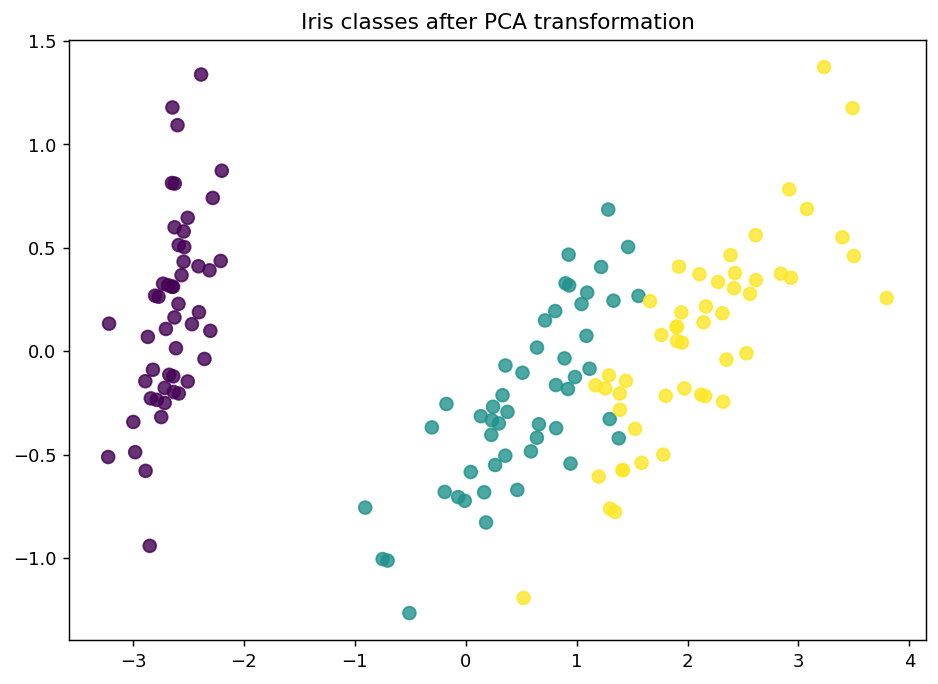

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Iris classes after PCA transformation')
plt.show()

In [6]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [8]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

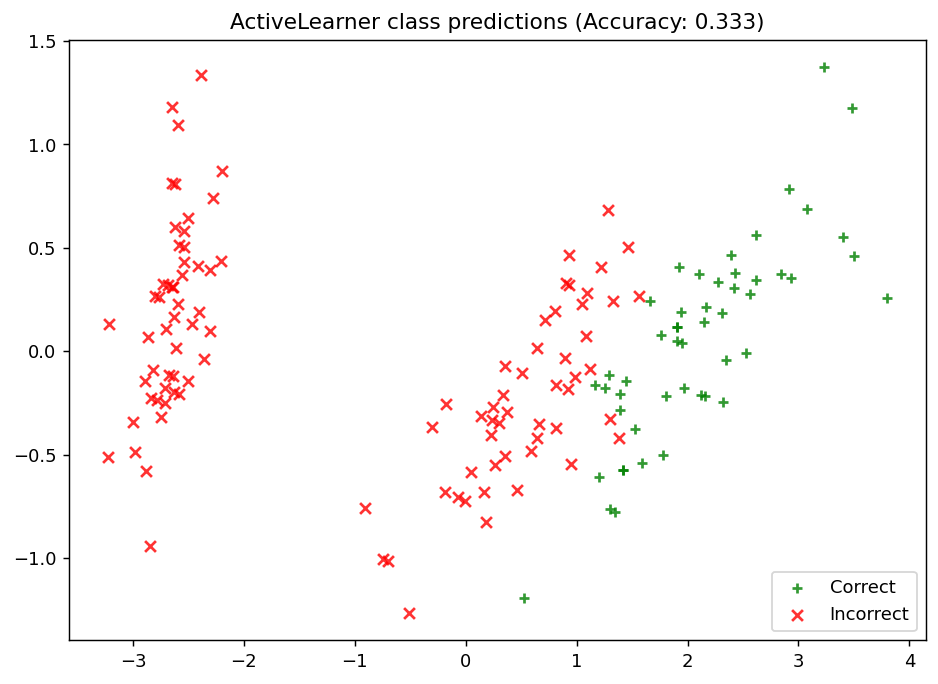

In [9]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [10]:
N_QUERIES = 20
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.6667
Accuracy after query 2: 0.6667
Accuracy after query 3: 0.8800
Accuracy after query 4: 0.8800
Accuracy after query 5: 0.8733
Accuracy after query 6: 0.8400
Accuracy after query 7: 0.7400
Accuracy after query 8: 0.7267
Accuracy after query 9: 0.7267
Accuracy after query 10: 0.7267
Accuracy after query 11: 0.7267
Accuracy after query 12: 0.7267
Accuracy after query 13: 0.7267
Accuracy after query 14: 0.7267
Accuracy after query 15: 0.7200
Accuracy after query 16: 0.8400
Accuracy after query 17: 0.8800
Accuracy after query 18: 0.8933
Accuracy after query 19: 0.9267
Accuracy after query 20: 0.9267


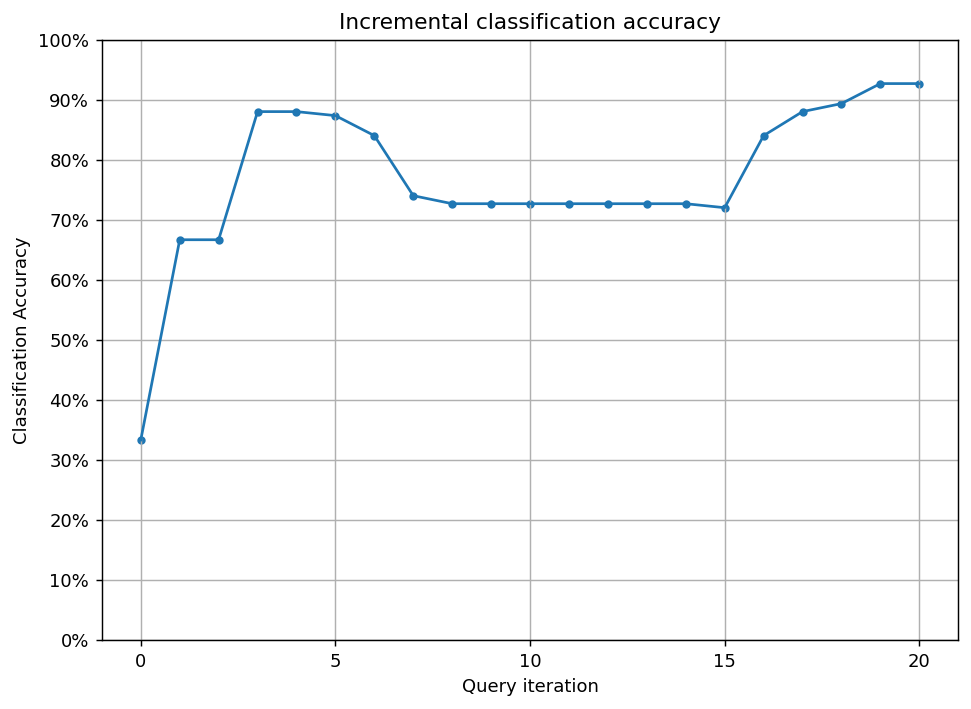

In [11]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

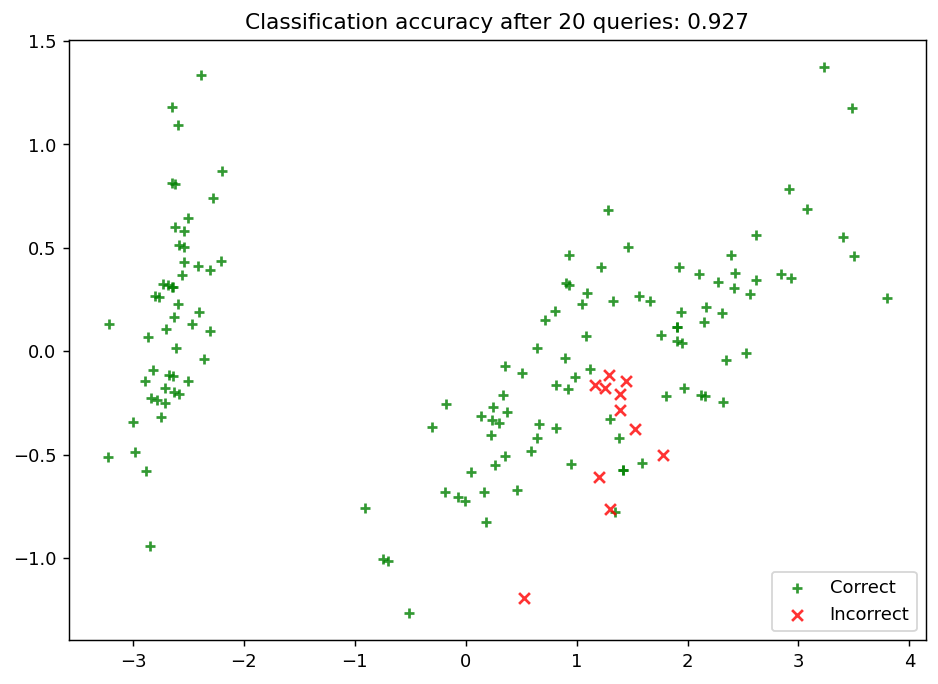

In [12]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()